In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(num_epochs, num_steps):
    for i in range(num_epochs):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [3]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""

def rnn_cell(rnn_input, state, state_size, num_classes):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    print("rnn_cell: W.name=%s b.name=%s" % (W.name,b.name))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [4]:
def output(rnn_outputs, state_size, num_classes, useDynamic=False):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    
    #logits and predictions
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    if useDynamic:
        print("rnn_outputs",type(rnn_outputs),rnn_outputs.shape)
        logits = tf.reshape(tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b, \
            [batch_size, num_steps, num_classes])
    else:
        print("rnn_outputs",type(rnn_outputs),len(rnn_outputs))
        logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
    print("output: W.name=%s b.name=%s" % (W.name,b.name))
    # predictions = [tf.nn.softmax(logit) for logit in logits]

    return logits

In [5]:
def cnn_net(x, batch_size, state_size, num_classes, useTF=False, useDynamic=False):
    if useDynamic:
        assert useTF == True
    
    init_state = tf.placeholder(tf.float32, shape=(batch_size, state_size), name='init_state')

    """
    RNN Inputs
    """
    # Turn our x placeholder into a list of one-hot tensors:
    # rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
    x_one_hot = tf.one_hot(x, num_classes)
    if useDynamic:
        rnn_inputs = x_one_hot
        print("rnn_inputs",type(rnn_inputs),rnn_inputs.shape)
    else:
        rnn_inputs = tf.unstack(x_one_hot, axis=1)
        print("rnn_inputs",type(rnn_inputs),len(rnn_inputs))

    """
    Adding rnn_cells to graph

    This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
    Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
    """
    if useTF:
        cell = tf.contrib.rnn.BasicRNNCell(state_size)
        print("BasicRNNCell: ",type(cell))
        if useDynamic:
            rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
        else:
            rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)
    else:
        # create cnn variables to reuse
        with tf.variable_scope('rnn_cell'):
            W = tf.get_variable('W', [num_classes + state_size, state_size])
            b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

        state = init_state
        rnn_outputs = []
        for rnn_input in rnn_inputs:
            state = rnn_cell(rnn_input, state, state_size, num_classes)
            rnn_outputs.append(state)
        final_state = rnn_outputs[-1]

        print("state", type(state), state.shape)
        
    print("init_state", type(init_state), init_state.shape)
    print("final_state", type(final_state), final_state.shape)
        
    logits = output(rnn_outputs, state_size, num_classes, useDynamic)
    
    if useDynamic:
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    else:
        # Turn our y placeholder into a list of labels
        y_as_list = tf.unstack(y, num=num_steps, axis=1)
        print("y_as_list",type(y_as_list),len(y_as_list))

        #losses and train_step
        losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
                  logit, label in zip(logits, y_as_list)]

    return [final_state, logits, losses]

In [6]:
"""
Train the network
"""

def train_network(final_state, logits, losses, total_loss, num_epochs, num_steps, state_size, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={'x:0':X, 'y:0':Y, 'init_state:0':training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

In [7]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 16
learning_rate = 0.1
useTF = True
useDynamic = True

"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='x')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='y')
print("x",type(x),x.shape)
print("y",type(y),y.shape)

final_state, logits, losses = cnn_net(x, batch_size, state_size, num_classes, useTF=useTF, useDynamic=useDynamic)
predictions = tf.nn.softmax(logits)

total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

x <class 'tensorflow.python.framework.ops.Tensor'> (200, 10)
y <class 'tensorflow.python.framework.ops.Tensor'> (200, 10)
rnn_inputs <class 'tensorflow.python.framework.ops.Tensor'> (200, 10, 2)
BasicRNNCell:  <class 'tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl.BasicRNNCell'>
init_state <class 'tensorflow.python.framework.ops.Tensor'> (200, 16)
final_state <class 'tensorflow.python.framework.ops.Tensor'> (200, 16)
rnn_outputs <class 'tensorflow.python.framework.ops.Tensor'> (200, 10, 16)
output: W.name=softmax/W:0 b.name=softmax/b:0



EPOCH 0
Average loss at step 100 for last 250 steps: 0.516372788846
Average loss at step 200 for last 250 steps: 0.482183126211
Average loss at step 300 for last 250 steps: 0.478338264227
Average loss at step 400 for last 250 steps: 0.472839602232


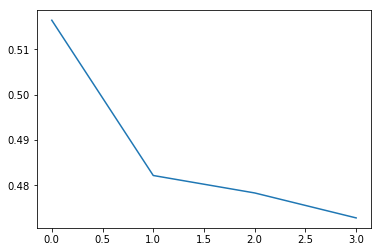

In [8]:
num_epochs = 1
training_losses = train_network(final_state, logits, losses, total_loss, num_epochs,num_steps,state_size)
plt.plot(training_losses)